### Input high volatility stocks as a list from https://www.investcom.com/us/most_volatile_us.htm

In [2]:
import requests
import pandas as pd
import json
import time
import numpy as np
import datetime
pd.set_option('display.max_rows', None)
stock_list =['TWOU','SGD','BW','INVO','OPTX','CAUD','MRAI','TMCI']
# stock_list =['TWOU','SGD','BW','INVO','OPTX','CAUD','MRAI','TMCI','GCTK','PLUG','CREV','TCON','OMIC','JGGC','FBIO','GRPN','ADPT',
#              'CANO','MNTK','GDOT','SNES','HRYU','EVA','SIEN','APVO','INBS','SNOA']

In [44]:
clause  = ",".join( f"{stock}" for stock in stock_list)
clause


stock_list

['TWOU', 'BW', 'INVO', 'MRAI', 'TMCI']

### Find how far back do you have the data for such stocks, we would like a years worth to do analysis

In [53]:
url = "https://twelve-data1.p.rapidapi.com/earliest_timestamp"

querystring = {"symbol":"BW","interval":"1min","outputsize":f"{len(stock_list)}"}

headers = {
	"X-RapidAPI-Key": "628945fc0cmsh40c2bcb4a06a38ap16df3cjsn9834d9b0ab25",
	"X-RapidAPI-Host": "twelve-data1.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

data = response.json()
df = pd.DataFrame(data)

{'datetime': '2020-02-07 12:54:00', 'unix_time': 1581098040}

### Find stocks you would like to remove and remove them from original list

In [29]:
now = datetime.datetime.now()
year_ago = now - datetime.timedelta(days=370)

unix_year_ago = int(year_ago.timestamp())
print(unix_year_ago)
datetime_obj = datetime.datetime.fromtimestamp(unix_year_ago)
print(datetime_obj)

1667868372
2022-11-07 17:46:12


In [38]:
for key in data:
    if 'datetime' not in data[key].keys() or data[key]['unix_time'] > unix_year_ago:
        stock_list.remove(key)

SGD {'datetime': '2023-09-28 09:30:00', 'unix_time': 1695907800}
OPTX {'code': 404, 'message': '**symbol** not found: OPTX. Please specify it correctly according to API Documentation.', 'status': 'error'}
CAUD {'code': 404, 'message': '**symbol** not found: CAUD. Please specify it correctly according to API Documentation.', 'status': 'error'}


### Create a function that creates date ranges , so that one does not need to paginate. The api has a limit of 5000 records in one go

In [67]:
def create_date_ranges(from_date_str, to_date_str):
    from_date_dt = datetime.datetime.strptime(from_date_str, '%Y-%m-%d')
    to_date_dt = datetime.datetime.strptime(to_date_str, '%Y-%m-%d')

    date_ranges = []

    while from_date_dt < to_date_dt:
        # Calculate the end date of the current 3-day range
        end_date = from_date_dt + datetime.timedelta(days=9)

        # Adjust the end date to not exceed the to_date_dt
        if end_date > to_date_dt:
            end_date = to_date_dt

        # Add the date range tuple to the list
        date_ranges.append((from_date_dt.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')))

        # Move to the next range
        from_date_dt = end_date + datetime.timedelta(days=1)

    return date_ranges


In [70]:
from_date = '2023-01-01'
to_date = '2023-11-14'
date_ranges = create_date_ranges(from_date, to_date)
print(date_ranges)
len(date_ranges)

[('2023-01-01', '2023-01-10'), ('2023-01-11', '2023-01-20'), ('2023-01-21', '2023-01-30'), ('2023-01-31', '2023-02-09'), ('2023-02-10', '2023-02-19'), ('2023-02-20', '2023-03-01'), ('2023-03-02', '2023-03-11'), ('2023-03-12', '2023-03-21'), ('2023-03-22', '2023-03-31'), ('2023-04-01', '2023-04-10'), ('2023-04-11', '2023-04-20'), ('2023-04-21', '2023-04-30'), ('2023-05-01', '2023-05-10'), ('2023-05-11', '2023-05-20'), ('2023-05-21', '2023-05-30'), ('2023-05-31', '2023-06-09'), ('2023-06-10', '2023-06-19'), ('2023-06-20', '2023-06-29'), ('2023-06-30', '2023-07-09'), ('2023-07-10', '2023-07-19'), ('2023-07-20', '2023-07-29'), ('2023-07-30', '2023-08-08'), ('2023-08-09', '2023-08-18'), ('2023-08-19', '2023-08-28'), ('2023-08-29', '2023-09-07'), ('2023-09-08', '2023-09-17'), ('2023-09-18', '2023-09-27'), ('2023-09-28', '2023-10-07'), ('2023-10-08', '2023-10-17'), ('2023-10-18', '2023-10-27'), ('2023-10-28', '2023-11-06'), ('2023-11-07', '2023-11-14')]


32

### Create a function that takes argument stock symbol and sleep count (sleep count will make sure the thread to sleep for more than a minute every time count gets exceeded. This is done so that we can make sure that we do not over exceed the api limits.) The function should return the data frame with the history in the end.

In [75]:
def get_stock_time_series(stock_symbol, sleep_count):
	url = "https://twelve-data1.p.rapidapi.com/time_series"
	# clause  = ",".join( f"{stock}" for stock in stock_list)
	# querystring = {"symbol":clause,"interval":"1min","start_date":date_ranges[0][0], "end_date":date_ranges[0][1],"format":"json"}
	df_stock_history = pd.DataFrame()
	cnt = 0 
	for from_date, to_date in date_ranges:
		cnt +=1
		if cnt % sleep_count == 0:
			time.sleep(70)
		# querystring = {"symbol":stock_symbol,"interval":"1min","start_date":date_ranges[0][0], "end_date":date_ranges[0][1],"format":"json","outputsize":"4999"}
		querystring = {"symbol":stock_symbol,"interval":"1min","start_date":from_date, "end_date":to_date,"format":"json","outputsize":"4999"}
		# querystring = {"symbol":"TWOU","interval":"1min","format":"json"}

		headers = {
			"X-RapidAPI-Key": "628945fc0cmsh40c2bcb4a06a38ap16df3cjsn9834d9b0ab25",
			"X-RapidAPI-Host": "twelve-data1.p.rapidapi.com"
		}

		response = requests.get(url, headers=headers, params=querystring)

		json_value = response.json()
		df_values = pd.DataFrame(json_value['values'])
		df_values['symbol'] = stock_symbol
		df_values['datetime'] = pd.to_datetime(df_values['datetime'])
		df_values['open'] = pd.to_numeric(df_values['open'])
		df_values['high'] = pd.to_numeric(df_values['high'])
		df_values['low'] = pd.to_numeric(df_values['low'])
		df_values['close'] = pd.to_numeric(df_values['close'])
		df_values['volume'] = pd.to_numeric(df_values['volume'])
		df_stock_history = pd.concat([df_stock_history, df_values], ignore_index=True)
		# df_stock_history = df_stock_history.append(df_values, ignore_index=True)
	return df_stock_history



In [76]:
df_stock_history = get_stock_time_series('TWOU',6)

In [79]:
df_stock_history.describe()

,datetime,open,high,low,close,volume
count,66330,66330.000000,66330.000000,66330.000000,66330.000000,66330.000000
mean,2023-06-08 19:42:46.331976448,4.969191,4.974375,4.964005,4.969211,3521.591452
min,2023-01-03 09:30:00,0.880000,0.880100,0.880000,0.880050,0.000000
25%,2023-03-20 13:42:30,3.160000,3.160000,3.155000,3.160000,500.000000
50%,2023-06-07 10:27:30,4.055000,4.060000,4.050000,4.055000,1218.000000
75%,2023-08-24 14:41:45,6.685000,6.690000,6.680000,6.685000,3062.000000
max,2023-11-13 15:59:00,13.120000,13.150000,13.100000,13.112400,690708.000000
std,NaN,2.513121,2.516119,2.510263,2.513191,10504.194261


In [80]:
df_stock_history.to_csv('TWOU.csv', index=False)

### Open saved csv and start added columns that we think will aide in better decision making. We will also create a label column that we would train for.

In [210]:
df_stock_history = pd.read_csv('TWOU.csv')


In [211]:
df_stock_history['datetime'] = pd.to_datetime(df_stock_history['datetime'])
df_stock_history = df_stock_history.sort_values(by='datetime', ignore_index=True)

df_stock_history.dtypes

datetime    datetime64[ns]
open               float64
high               float64
low                float64
close              float64
volume               int64
symbol              object
dtype: object

In [212]:
df_stock_history.describe()

,datetime,open,high,low,close,volume
count,66330,66330.000000,66330.000000,66330.000000,66330.000000,66330.000000
mean,2023-06-08 19:42:46.331976704,4.969191,4.974375,4.964005,4.969211,3521.591452
min,2023-01-03 09:30:00,0.880000,0.880100,0.880000,0.880050,0.000000
25%,2023-03-20 13:42:30,3.160000,3.160000,3.155000,3.160000,500.000000
50%,2023-06-07 10:27:30,4.055000,4.060000,4.050000,4.055000,1218.000000
75%,2023-08-24 14:41:45,6.685000,6.690000,6.680000,6.685000,3062.000000
max,2023-11-13 15:59:00,13.120000,13.150000,13.100000,13.112400,690708.000000
std,NaN,2.513121,2.516119,2.510263,2.513191,10504.194261


In [213]:
df_stock_history.groupby(df_stock_history['datetime'].dt.date).count().head()

,datetime,open,high,low,close,volume,symbol
datetime,,,,,,,
2023-01-03,341,341,341,341,341,341,341
2023-01-04,327,327,327,327,327,327,327
2023-01-05,358,358,358,358,358,358,358
2023-01-06,301,301,301,301,301,301,301
2023-01-09,353,353,353,353,353,353,353


In [214]:
df_stock_history[df_stock_history['datetime'].dt.date == pd.to_datetime('2023-01-03').date()].head()

,datetime,open,high,low,close,volume,symbol
0,2023-01-03 09:30:00,6.440,6.580,6.44,6.535,25540,TWOU
1,2023-01-03 09:31:00,6.565,6.565,6.51,6.555,2860,TWOU
2,2023-01-03 09:32:00,6.510,6.540,6.51,6.540,1232,TWOU
3,2023-01-03 09:33:00,6.530,6.560,6.53,6.550,1385,TWOU
4,2023-01-03 09:34:00,6.590,6.610,6.57,6.610,3474,TWOU


### We know that we have missing rows , this could happen in real life situations as well. We have two options one would be to fill them with dummy rows. How do calculate these could be as simple as duplicating the last ones. This might not be the best approach and can create more backage down stream. The second approach would be create a feature called distance to last row, we could use it to analyse our model and see if that provides better intuition as well. This column will also help us arrive at labels.


In [215]:
df_stock_history['time_diff_seconds'] = df_stock_history['datetime'].diff().dt.total_seconds()

In [216]:
df_stock_history.head()

,datetime,open,high,low,close,volume,symbol,time_diff_seconds
0,2023-01-03 09:30:00,6.440,6.580,6.44,6.535,25540,TWOU,NaN
1,2023-01-03 09:31:00,6.565,6.565,6.51,6.555,2860,TWOU,60.0
2,2023-01-03 09:32:00,6.510,6.540,6.51,6.540,1232,TWOU,60.0
3,2023-01-03 09:33:00,6.530,6.560,6.53,6.550,1385,TWOU,60.0
4,2023-01-03 09:34:00,6.590,6.610,6.57,6.610,3474,TWOU,60.0


In [217]:
def add_labels(df):
    df['cumsum'] = df['time_diff_seconds'].cumsum()
    df['next_1_hr_datetime'] = pd.NaT
    df['max_pct_datetime'] = pd.NaT
    df['min_pct_datetime'] = pd.NaT
    df['label_next_1_hr_close'] = np.nan
    df['label_max_pct_close']= np.nan
    df['label_min_pct_close']= np.nan
    for i in range(len(df)):
        # Find the index where cumsum reaches or exceeds 3600 more than the current cumsum
        target_cumsum = df.at[i, 'cumsum'] + 3600
        current_close = df.at[i, 'close']
        next_index = df[df['cumsum'] <= target_cumsum].index.max()
        # If such an index exists, retrieve the datetime
        if pd.notna(next_index):
            df.at[i, 'next_1_hr_datetime'] = df.at[next_index, 'datetime']
            df.at[i, 'label_next_1_hr_close'] = df.at[next_index, 'close']
            max_value_index = df.loc[i:next_index, 'close'].idxmax()
            df.at[i, 'label_max_pct_close'] = df.at[max_value_index, 'close']
            df.at[i, 'max_pct_datetime'] = df.at[max_value_index, 'datetime']
            min_value_index = df.loc[i:next_index, 'close'].idxmin()
            df.at[i, 'label_min_pct_close'] = df.at[min_value_index, 'close']
            df.at[i, 'min_pct_datetime'] = df.at[min_value_index, 'datetime']

    return df

In [218]:
df_stock_history = add_labels(df_stock_history)

In [219]:
df_stock_history.head(5)

,datetime,open,high,low,close,volume,symbol,time_diff_seconds,cumsum,next_1_hr_datetime,max_pct_datetime,min_pct_datetime,label_next_1_hr_close,label_max_pct_close,label_min_pct_close
0,2023-01-03 09:30:00,6.440,6.580,6.44,6.535,25540,TWOU,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN
1,2023-01-03 09:31:00,6.565,6.565,6.51,6.555,2860,TWOU,60.0,60.0,2023-01-03 10:31:00,2023-01-03 09:44:00,2023-01-03 10:19:00,6.15,6.65,6.12
2,2023-01-03 09:32:00,6.510,6.540,6.51,6.540,1232,TWOU,60.0,120.0,2023-01-03 10:32:00,2023-01-03 09:44:00,2023-01-03 10:19:00,6.15,6.65,6.12
3,2023-01-03 09:33:00,6.530,6.560,6.53,6.550,1385,TWOU,60.0,180.0,2023-01-03 10:33:00,2023-01-03 09:44:00,2023-01-03 10:19:00,6.14,6.65,6.12
4,2023-01-03 09:34:00,6.590,6.610,6.57,6.610,3474,TWOU,60.0,240.0,2023-01-03 10:33:00,2023-01-03 09:44:00,2023-01-03 10:19:00,6.14,6.65,6.12


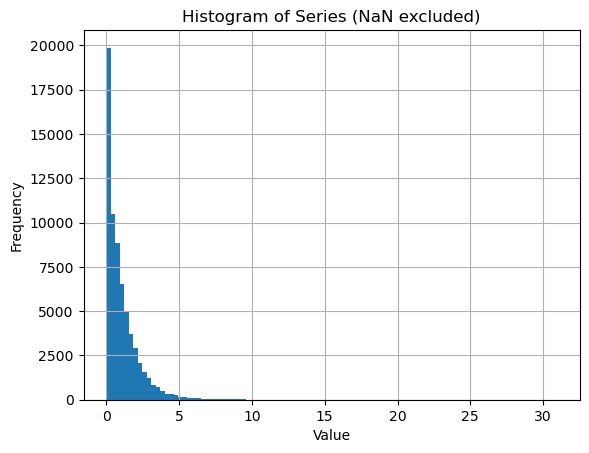

In [220]:
import matplotlib.pyplot as plt
df_stock_history['label_call_pct'] = ((df_stock_history['label_max_pct_close']  - df_stock_history['close'])*100/df_stock_history['close'])
df_stock_history['label_put_pct'] = ((df_stock_history['close'] - df_stock_history['label_min_pct_close'] )*100/df_stock_history['close'])
call_series = df_stock_history['label_call_pct'].dropna()
put_series = df_stock_history['label_put_pct'].dropna()
call_series.hist(bins=100)
plt.title('Histogram of Series (NaN excluded)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

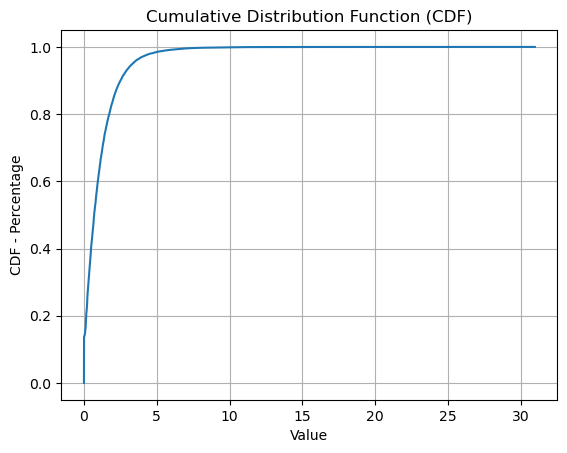

In [221]:
# Sort the data
data_sorted = np.sort(call_series)

# Calculate CDF values
cdf = np.arange(len(data_sorted)) / float(len(data_sorted))

# Plot CDF
plt.plot(data_sorted, cdf)
plt.title('Cumulative Distribution Function (CDF)')
plt.xlabel('Value')
plt.ylabel('CDF - Percentage')
plt.grid(True)
plt.show()

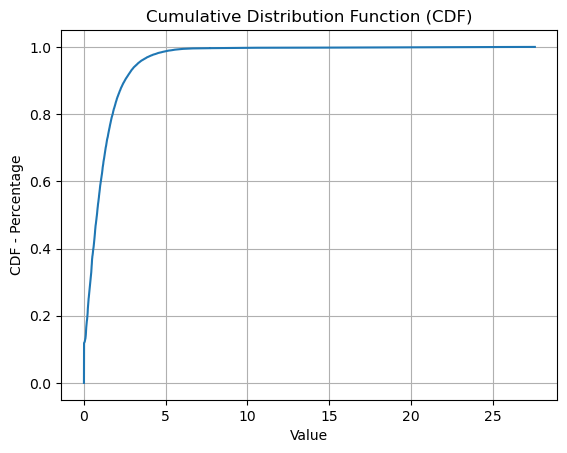

In [222]:
# Sort the data
data_sorted = np.sort(abs(put_series))

# Calculate CDF values
cdf = np.arange(len(data_sorted)) / float(len(data_sorted))

# Plot CDF
plt.plot(data_sorted, cdf)
plt.title('Cumulative Distribution Function (CDF)')
plt.xlabel('Value')
plt.ylabel('CDF - Percentage')
plt.grid(True)
plt.show()

In [223]:
df_stock_history.columns

correlation_call = df_stock_history['volume'].corr(df_stock_history['label_call_pct'])
correlation_put = df_stock_history['volume'].corr(df_stock_history['label_put_pct'])
print(correlation_call,correlation_put)

0.10223909105348591 0.1338693202340719


In [224]:
t = df_stock_history['close'].ewm(span=12, adjust=False).mean()

In [225]:
def add_macd_column(df):
    """
    Adds a MACD (Moving Average Convergence Divergence) column to the DataFrame.

    Parameters:
    df (DataFrame): Pandas DataFrame containing stock data with 'close' prices.

    Returns:
    DataFrame: Original DataFrame with an added 'MACD' column.
    """
    # Short term exponential moving average (EMA)
    # Typically, a 12-period EMA is used for the short term EMA
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()

    # Long term exponential moving average (EMA)
    # Typically, a 26-period EMA is used for the long term EMA
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()

    # MACD is the difference between the 12-period EMA and the 26-period EMA
    df['macd'] = ema_12 - ema_26
    df['macd_signal_line'] = df['macd'].ewm(span=9, adjust=False).mean()

    return df

In [226]:
df_stock_history = add_macd_column(df_stock_history)

In [227]:
correlation_macd = (df_stock_history['macd']-df_stock_history['macd_signal_line']).corr(df_stock_history['label_call_pct'])
print(correlation_macd)
df_stock_history.head()

0.01622780029135022


,datetime,open,high,low,close,volume,symbol,time_diff_seconds,cumsum,next_1_hr_datetime,max_pct_datetime,min_pct_datetime,label_next_1_hr_close,label_max_pct_close,label_min_pct_close,label_call_pct,label_put_pct,macd,macd_signal_line
0,2023-01-03 09:30:00,6.440,6.580,6.44,6.535,25540,TWOU,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2023-01-03 09:31:00,6.565,6.565,6.51,6.555,2860,TWOU,60.0,60.0,2023-01-03 10:31:00,2023-01-03 09:44:00,2023-01-03 10:19:00,6.15,6.65,6.12,1.449275,6.636156,0.001595,0.000319
2,2023-01-03 09:32:00,6.510,6.540,6.51,6.540,1232,TWOU,60.0,120.0,2023-01-03 10:32:00,2023-01-03 09:44:00,2023-01-03 10:19:00,6.15,6.65,6.12,1.681957,6.422018,0.001631,0.000581
3,2023-01-03 09:33:00,6.530,6.560,6.53,6.550,1385,TWOU,60.0,180.0,2023-01-03 10:33:00,2023-01-03 09:44:00,2023-01-03 10:19:00,6.14,6.65,6.12,1.526718,6.564885,0.002437,0.000953
4,2023-01-03 09:34:00,6.590,6.610,6.57,6.610,3474,TWOU,60.0,240.0,2023-01-03 10:33:00,2023-01-03 09:44:00,2023-01-03 10:19:00,6.14,6.65,6.12,0.605144,7.413011,0.007828,0.002328


In [235]:
def calculate_rsi(df, column='close', period=14):
    """
    Calculate the Relative Strength Index (RSI) for a given DataFrame.

    Parameters:
    df (DataFrame): Pandas DataFrame containing stock data.
    column (str): Name of the column to calculate RSI on, typically 'close'.
    period (int): The period to use for calculating RSI, typically 14.

    Returns:
    DataFrame: Original DataFrame with an added 'RSI' column.
    """
    # Calculate daily price changes
    delta = df[column].diff(1)

    # Separate gains and losses
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    # Calculate the Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the Relative Strength Index (RSI)
    df['rsi'] = 100 - (100 / (1 + rs))

    return df

In [236]:
df_stock_history = calculate_rsi(df_stock_history)

In [237]:
df_stock_history.head(16)

,datetime,open,high,low,close,volume,symbol,time_diff_seconds,cumsum,next_1_hr_datetime,...,min_pct_datetime,label_next_1_hr_close,label_max_pct_close,label_min_pct_close,label_call_pct,label_put_pct,macd,macd_signal_line,RSI,rsi
0,2023-01-03 09:30:00,6.440,6.580,6.440,6.535,25540,TWOU,NaN,NaN,NaT,...,NaT,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
1,2023-01-03 09:31:00,6.565,6.565,6.510,6.555,2860,TWOU,60.0,60.0,2023-01-03 10:31:00,...,2023-01-03 10:19:00,6.150,6.65,6.12,1.449275,6.636156,0.001595,0.000319,NaN,NaN
2,2023-01-03 09:32:00,6.510,6.540,6.510,6.540,1232,TWOU,60.0,120.0,2023-01-03 10:32:00,...,2023-01-03 10:19:00,6.150,6.65,6.12,1.681957,6.422018,0.001631,0.000581,NaN,NaN
3,2023-01-03 09:33:00,6.530,6.560,6.530,6.550,1385,TWOU,60.0,180.0,2023-01-03 10:33:00,...,2023-01-03 10:19:00,6.140,6.65,6.12,1.526718,6.564885,0.002437,0.000953,NaN,NaN
4,2023-01-03 09:34:00,6.590,6.610,6.570,6.610,3474,TWOU,60.0,240.0,2023-01-03 10:33:00,...,2023-01-03 10:19:00,6.140,6.65,6.12,0.605144,7.413011,0.007828,0.002328,NaN,NaN
5,2023-01-03 09:35:00,6.610,6.620,6.590,6.610,1826,TWOU,60.0,300.0,2023-01-03 10:35:00,...,2023-01-03 10:19:00,6.145,6.65,6.12,0.605144,7.413011,0.011962,0.004255,NaN,NaN
6,2023-01-03 09:36:00,6.610,6.610,6.600,6.600,568,TWOU,60.0,360.0,2023-01-03 10:36:00,...,2023-01-03 10:36:00,6.110,6.65,6.11,0.757576,7.424242,0.014267,0.006257,NaN,NaN
7,2023-01-03 09:37:00,6.600,6.640,6.600,6.600,1519,TWOU,60.0,420.0,2023-01-03 10:37:00,...,2023-01-03 10:36:00,6.120,6.65,6.11,0.757576,7.424242,0.015911,0.008188,NaN,NaN
8,2023-01-03 09:38:00,6.620,6.620,6.510,6.510,3250,TWOU,60.0,480.0,2023-01-03 10:38:00,...,2023-01-03 10:36:00,6.150,6.65,6.11,2.150538,6.144393,0.009837,0.008518,NaN,NaN
9,2023-01-03 09:39:00,6.510,6.640,6.500,6.630,14634,TWOU,60.0,540.0,2023-01-03 10:39:00,...,2023-01-03 10:36:00,6.120,6.65,6.11,0.301659,7.843137,0.014540,0.009722,NaN,NaN


In [239]:
correlation_rsi = (df_stock_history['rsi']).corr(df_stock_history['label_call_pct'])


0.007484369499757421

In [240]:
df_stock_history.describe()

,datetime,open,high,low,close,volume,time_diff_seconds,cumsum,next_1_hr_datetime,max_pct_datetime,min_pct_datetime,label_next_1_hr_close,label_max_pct_close,label_min_pct_close,label_call_pct,label_put_pct,macd,macd_signal_line,RSI,rsi
count,66330,66330.000000,66330.000000,66330.000000,66330.000000,66330.000000,66329.000000,6.632900e+04,66329,66329,66329,66329.000000,66329.000000,66329.000000,66329.000000,66329.000000,66330.000000,66330.000000,66304.000000,66304.000000
mean,2023-06-08 19:42:46.331976704,4.969191,4.974375,4.964005,4.969211,3521.591452,409.367547,1.351537e+07,2023-06-08 20:40:46.951408896,2023-06-08 20:09:32.349651200,2023-06-08 20:11:28.880580352,4.967546,5.022191,4.915312,1.062710,1.125472,-0.000593,-0.000593,49.364730,49.364730
min,2023-01-03 09:30:00,0.880000,0.880100,0.880000,0.880050,0.000000,60.000000,6.000000e+01,2023-01-03 10:31:00,2023-01-03 09:44:00,2023-01-03 10:19:00,0.880050,0.906100,0.880050,0.000000,0.000000,-0.368878,-0.323446,0.000000,0.000000
25%,2023-03-20 13:42:30,3.160000,3.160000,3.155000,3.160000,500.000000,60.000000,6.581640e+06,2023-03-20 14:44:00,2023-03-20 13:53:00,2023-03-20 14:40:00,3.155000,3.190000,3.130000,0.230947,0.284091,-0.007419,-0.007094,37.500000,37.500000
50%,2023-06-07 10:27:30,4.055000,4.060000,4.050000,4.055000,1218.000000,60.000000,1.339548e+07,2023-06-07 11:28:00,2023-06-07 11:10:00,2023-06-07 10:28:00,4.055000,4.100000,4.010000,0.698254,0.792864,-0.000731,-0.000728,50.000000,50.000000
75%,2023-08-24 14:41:45,6.685000,6.690000,6.680000,6.685000,3062.000000,60.000000,2.014992e+07,2023-08-24 15:42:00,2023-08-24 15:19:00,2023-08-24 14:44:00,6.655000,6.730000,6.612500,1.471030,1.521984,0.006070,0.005784,61.186065,61.186065
max,2023-11-13 15:59:00,13.120000,13.150000,13.100000,13.112400,690708.000000,408660.000000,2.715294e+07,2023-11-13 15:59:00,2023-11-13 15:59:00,2023-11-13 15:59:00,13.112400,13.112400,12.790000,30.955882,27.587863,0.474413,0.436190,100.000000,100.000000
std,NaN,2.513121,2.516119,2.510263,2.513191,10504.194261,7890.170444,7.843078e+06,NaN,NaN,NaN,2.517929,2.544621,2.487281,1.231909,1.457778,0.022569,0.021371,17.402103,17.402103


In [241]:
def calculate_vwap_daily_reset(df):
    """
    Calculate the Volume Weighted Average Price (VWAP) for a given DataFrame, resetting it daily.

    Parameters:
    df (DataFrame): Pandas DataFrame containing stock data with 'datetime', 'high', 'low', 'close', and 'volume'.

    Returns:
    DataFrame: Original DataFrame with an added 'VWAP' column, calculated on a daily basis.
    """
    # Group data by date (assuming 'datetime' is already in a suitable format)
    df['date'] = df['datetime'].dt.date
    grouped = df.groupby('date')

    # Function to calculate VWAP for each group (i.e., each day)
    def calculate_vwap(group):
        tp_volume = (group['high'] + group['low'] + group['close']) / 3 * group['volume']
        return tp_volume.cumsum() / group['volume'].cumsum()

    # Apply the function to each group
    vwap_daily = grouped.apply(calculate_vwap)

    # Flatten the resulting multi-index DataFrame and align it with the original DataFrame
    df['vwap'] = vwap_daily.reset_index(level=0, drop=True)

    # Remove the temporary 'date' column
    df.drop(columns=['date'], inplace=True)

    return df

In [242]:
df_stock_history = calculate_vwap_daily_reset(df_stock_history)

In [243]:
df_stock_history.head()

,datetime,open,high,low,close,volume,symbol,time_diff_seconds,cumsum,next_1_hr_datetime,...,label_next_1_hr_close,label_max_pct_close,label_min_pct_close,label_call_pct,label_put_pct,macd,macd_signal_line,RSI,rsi,VWAP
0,2023-01-03 09:30:00,6.440,6.580,6.44,6.535,25540,TWOU,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,6.518333
1,2023-01-03 09:31:00,6.565,6.565,6.51,6.555,2860,TWOU,60.0,60.0,2023-01-03 10:31:00,...,6.15,6.65,6.12,1.449275,6.636156,0.001595,0.000319,NaN,NaN,6.520851
2,2023-01-03 09:32:00,6.510,6.540,6.51,6.540,1232,TWOU,60.0,120.0,2023-01-03 10:32:00,...,6.15,6.65,6.12,1.681957,6.422018,0.001631,0.000581,NaN,NaN,6.521231
3,2023-01-03 09:33:00,6.530,6.560,6.53,6.550,1385,TWOU,60.0,180.0,2023-01-03 10:33:00,...,6.14,6.65,6.12,1.526718,6.564885,0.002437,0.000953,NaN,NaN,6.522367
4,2023-01-03 09:34:00,6.590,6.610,6.57,6.610,3474,TWOU,60.0,240.0,2023-01-03 10:33:00,...,6.14,6.65,6.12,0.605144,7.413011,0.007828,0.002328,NaN,NaN,6.529851


In [244]:
def calculate_bollinger_bands(df, column='close', period=60, std_dev_multiplier=2):
    """
    Calculate Bollinger Bands for intraday trading with minute-by-minute data.

    Parameters:
    df (DataFrame): DataFrame with minute-by-minute stock data.
    column (str): The name of the column to calculate Bollinger Bands for, typically 'close'.
    period (int): Number of minutes for the moving average and standard deviation.
    std_dev_multiplier (int): Multiplier for the standard deviation to create the bands.

    Returns:
    DataFrame: Modified DataFrame with added Bollinger Bands columns.
    """
    # Middle Band (SMA)
    df['Middle Band'] = df[column].rolling(window=period).mean()

    # Standard Deviation
    df['STD'] = df[column].rolling(window=period).std()

    # Upper and Lower Bands
    df['Upper Band'] = df['Middle Band'] + (df['STD'] * std_dev_multiplier)
    df['Lower Band'] = df['Middle Band'] - (df['STD'] * std_dev_multiplier)

    return df

In [245]:
df_stock_history = calculate_bollinger_bands(df_stock_history)

In [248]:
df_stock_history.head(70)

,datetime,open,high,low,close,volume,symbol,time_diff_seconds,cumsum,next_1_hr_datetime,...,label_put_pct,macd,macd_signal_line,RSI,rsi,VWAP,Middle Band,STD,Upper Band,Lower Band
0,2023-01-03 09:30:00,6.4400,6.5800,6.4400,6.5350,25540,TWOU,NaN,NaN,NaT,...,NaN,0.000000,0.000000,NaN,NaN,6.518333,NaN,NaN,NaN,NaN
1,2023-01-03 09:31:00,6.5650,6.5650,6.5100,6.5550,2860,TWOU,60.0,60.0,2023-01-03 10:31:00,...,6.636156,0.001595,0.000319,NaN,NaN,6.520851,NaN,NaN,NaN,NaN
2,2023-01-03 09:32:00,6.5100,6.5400,6.5100,6.5400,1232,TWOU,60.0,120.0,2023-01-03 10:32:00,...,6.422018,0.001631,0.000581,NaN,NaN,6.521231,NaN,NaN,NaN,NaN
3,2023-01-03 09:33:00,6.5300,6.5600,6.5300,6.5500,1385,TWOU,60.0,180.0,2023-01-03 10:33:00,...,6.564885,0.002437,0.000953,NaN,NaN,6.522367,NaN,NaN,NaN,NaN
4,2023-01-03 09:34:00,6.5900,6.6100,6.5700,6.6100,3474,TWOU,60.0,240.0,2023-01-03 10:33:00,...,7.413011,0.007828,0.002328,NaN,NaN,6.529851,NaN,NaN,NaN,NaN
5,2023-01-03 09:35:00,6.6100,6.6200,6.5900,6.6100,1826,TWOU,60.0,300.0,2023-01-03 10:35:00,...,7.413011,0.011962,0.004255,NaN,NaN,6.533713,NaN,NaN,NaN,NaN
6,2023-01-03 09:36:00,6.6100,6.6100,6.6000,6.6000,568,TWOU,60.0,360.0,2023-01-03 10:36:00,...,7.424242,0.014267,0.006257,NaN,NaN,6.534785,NaN,NaN,NaN,NaN
7,2023-01-03 09:37:00,6.6000,6.6400,6.6000,6.6000,1519,TWOU,60.0,420.0,2023-01-03 10:37:00,...,7.424242,0.015911,0.008188,NaN,NaN,6.537892,NaN,NaN,NaN,NaN
8,2023-01-03 09:38:00,6.6200,6.6200,6.5100,6.5100,3250,TWOU,60.0,480.0,2023-01-03 10:38:00,...,6.144393,0.009837,0.008518,NaN,NaN,6.538577,NaN,NaN,NaN,NaN
9,2023-01-03 09:39:00,6.5100,6.6400,6.5000,6.6300,14634,TWOU,60.0,540.0,2023-01-03 10:39:00,...,7.843137,0.014540,0.009722,NaN,NaN,6.551946,NaN,NaN,NaN,NaN


In [249]:
df_stock_history.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'symbol',
       'time_diff_seconds', 'cumsum', 'next_1_hr_datetime', 'max_pct_datetime',
       'min_pct_datetime', 'label_next_1_hr_close', 'label_max_pct_close',
       'label_min_pct_close', 'label_call_pct', 'label_put_pct', 'macd',
       'macd_signal_line', 'RSI', 'rsi', 'VWAP', 'Middle Band', 'STD',
       'Upper Band', 'Lower Band'],
      dtype='object')

In [251]:
df_stock_history['category_call'] = np.where(df_stock_history['label_max_pct_close'] >= df_stock_history['close'] * 1.02, 'Positive', 'Neutral')
df_stock_history['category_put'] = np.where(df_stock_history['label_min_pct_close'] <= df_stock_history['close'] * 0.98, 'Negative', 'Neutral')

In [252]:
conditions = [
    (df_stock_history['category_call'] == 'Positive') & (df_stock_history['category_put'] == 'Negative'),
    (df_stock_history['category_call'] == 'Positive'),
    (df_stock_history['category_put'] == 'Negative')
]

# Define choices corresponding to the conditions
choices = ['Both', 'Positive', 'Negative']

# Create new column using numpy.select
df_stock_history['category'] = np.select(conditions, choices, default='Neutral')


In [258]:
df_stock_history[['datetime','close','volume','label_max_pct_close','label_min_pct_close','category','macd',
'macd_signal_line', 'RSI', 'rsi', 'VWAP', 'Middle Band','Upper Band', 'Lower Band']].head(10)


,datetime,close,volume,label_max_pct_close,label_min_pct_close,category,macd,macd_signal_line,RSI,rsi,VWAP,Middle Band,Upper Band,Lower Band
0,2023-01-03 09:30:00,6.535,25540,NaN,NaN,Neutral,0.000000,0.000000,NaN,NaN,6.518333,NaN,NaN,NaN
1,2023-01-03 09:31:00,6.555,2860,6.65,6.12,Negative,0.001595,0.000319,NaN,NaN,6.520851,NaN,NaN,NaN
2,2023-01-03 09:32:00,6.540,1232,6.65,6.12,Negative,0.001631,0.000581,NaN,NaN,6.521231,NaN,NaN,NaN
3,2023-01-03 09:33:00,6.550,1385,6.65,6.12,Negative,0.002437,0.000953,NaN,NaN,6.522367,NaN,NaN,NaN
4,2023-01-03 09:34:00,6.610,3474,6.65,6.12,Negative,0.007828,0.002328,NaN,NaN,6.529851,NaN,NaN,NaN
5,2023-01-03 09:35:00,6.610,1826,6.65,6.12,Negative,0.011962,0.004255,NaN,NaN,6.533713,NaN,NaN,NaN
6,2023-01-03 09:36:00,6.600,568,6.65,6.11,Negative,0.014267,0.006257,NaN,NaN,6.534785,NaN,NaN,NaN
7,2023-01-03 09:37:00,6.600,1519,6.65,6.11,Negative,0.015911,0.008188,NaN,NaN,6.537892,NaN,NaN,NaN
8,2023-01-03 09:38:00,6.510,3250,6.65,6.11,Both,0.009837,0.008518,NaN,NaN,6.538577,NaN,NaN,NaN
9,2023-01-03 09:39:00,6.630,14634,6.65,6.11,Negative,0.014540,0.009722,NaN,NaN,6.551946,NaN,NaN,NaN


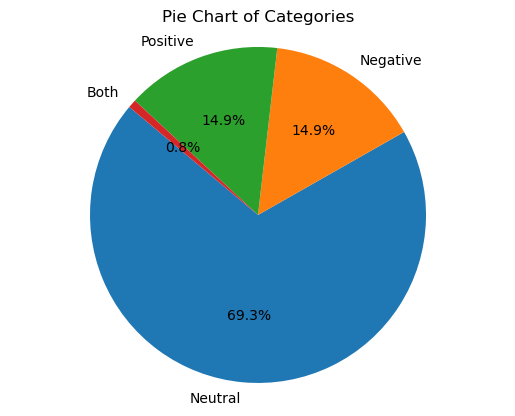

In [257]:
category_counts = df_stock_history['category'].value_counts()

# Create a pie chart
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add a title
plt.title('Pie Chart of Categories')

# Show the plot
plt.show()

In [259]:
df_stock_history.to_csv('TWOU_with_features.csv', index=False)


In [3]:
df_stock_history = pd.read_csv('TWOU_with_features.csv')
df_stock_history['datetime'] = pd.to_datetime(df_stock_history['datetime'])
df_stock_history = df_stock_history.sort_values(by='datetime', ignore_index=True)

df_stock_history.dtypes


datetime                 datetime64[ns]
open                            float64
high                            float64
low                             float64
close                           float64
volume                            int64
symbol                           object
time_diff_seconds               float64
cumsum                          float64
next_1_hr_datetime               object
max_pct_datetime                 object
min_pct_datetime                 object
label_next_1_hr_close           float64
label_max_pct_close             float64
label_min_pct_close             float64
label_call_pct                  float64
label_put_pct                   float64
macd                            float64
macd_signal_line                float64
RSI                             float64
rsi                             float64
VWAP                            float64
Middle Band                     float64
STD                             float64
Upper Band                      float64


In [4]:
df_stock_history.head()

,datetime,open,high,low,close,volume,symbol,time_diff_seconds,cumsum,next_1_hr_datetime,...,RSI,rsi,VWAP,Middle Band,STD,Upper Band,Lower Band,category_call,category_put,category
0,2023-01-03 09:30:00,6.440,6.580,6.44,6.535,25540,TWOU,NaN,NaN,NaN,...,NaN,NaN,6.518333,NaN,NaN,NaN,NaN,Neutral,Neutral,Neutral
1,2023-01-03 09:31:00,6.565,6.565,6.51,6.555,2860,TWOU,60.0,60.0,2023-01-03 10:31:00,...,NaN,NaN,6.520851,NaN,NaN,NaN,NaN,Neutral,Negative,Negative
2,2023-01-03 09:32:00,6.510,6.540,6.51,6.540,1232,TWOU,60.0,120.0,2023-01-03 10:32:00,...,NaN,NaN,6.521231,NaN,NaN,NaN,NaN,Neutral,Negative,Negative
3,2023-01-03 09:33:00,6.530,6.560,6.53,6.550,1385,TWOU,60.0,180.0,2023-01-03 10:33:00,...,NaN,NaN,6.522367,NaN,NaN,NaN,NaN,Neutral,Negative,Negative
4,2023-01-03 09:34:00,6.590,6.610,6.57,6.610,3474,TWOU,60.0,240.0,2023-01-03 10:33:00,...,NaN,NaN,6.529851,NaN,NaN,NaN,NaN,Neutral,Negative,Negative


In [5]:
df_stock_history[['datetime','close','volume','label_max_pct_close','label_min_pct_close','category','macd',
'macd_signal_line', 'RSI', 'rsi', 'VWAP', 'Middle Band','Upper Band', 'Lower Band']].iloc[60:][df_stock_history.isna().any(axis=1)]

/var/folders/_z/f324391j2yx7bn767ljdmm480000gp/T/ipykernel_14585/3457724623.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_stock_history[['datetime','close','volume','label_max_pct_close','label_min_pct_close','category','macd',


,datetime,close,volume,label_max_pct_close,label_min_pct_close,category,macd,macd_signal_line,RSI,rsi,VWAP,Middle Band,Upper Band,Lower Band
27969,2023-05-12 14:24:00,3.490,410,3.490,3.4500,Neutral,0.002028,0.002561,NaN,NaN,3.491487,3.481112,3.502376,3.459847
27970,2023-05-12 14:26:00,3.490,200,3.490,3.4500,Neutral,0.001904,0.002429,NaN,NaN,3.491487,3.481612,3.502259,3.460964
31764,2023-06-01 09:30:00,3.960,0,4.015,3.9050,Neutral,0.013246,0.013892,55.172414,55.172414,NaN,3.927583,3.982618,3.872549
36333,2023-06-22 14:48:00,3.795,605,3.810,3.7350,Neutral,0.001393,0.001825,NaN,NaN,3.757139,3.787525,3.806732,3.768318
36334,2023-06-22 14:49:00,3.795,547,3.810,3.7350,Neutral,0.001300,0.001720,NaN,NaN,3.757160,3.788025,3.806390,3.769660
36335,2023-06-22 14:50:00,3.795,588,3.810,3.7350,Neutral,0.001212,0.001618,NaN,NaN,3.757184,3.788525,3.805949,3.771101
36336,2023-06-22 14:51:00,3.795,349,3.810,3.7350,Neutral,0.001130,0.001520,NaN,NaN,3.757197,3.789025,3.805393,3.772657
36337,2023-06-22 14:52:00,3.795,112,3.810,3.7350,Neutral,0.001053,0.001427,NaN,NaN,3.757202,3.789358,3.805375,3.773341
36338,2023-06-22 14:53:00,3.795,246,3.810,3.7350,Neutral,0.000980,0.001337,NaN,NaN,3.757211,3.789775,3.805026,3.774524
36339,2023-06-22 14:54:00,3.795,245,3.810,3.7350,Neutral,0.000912,0.001252,NaN,NaN,3.757221,3.790108,3.804913,3.775303


In [6]:
df_stock = df_stock_history[['datetime','close','volume','label_max_pct_close','label_min_pct_close','category','macd',
'macd_signal_line', 'RSI', 'rsi', 'VWAP', 'Middle Band','Upper Band', 'Lower Band']].iloc[60:].dropna()

In [7]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66255 entries, 60 to 66329
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             66255 non-null  datetime64[ns]
 1   close                66255 non-null  float64       
 2   volume               66255 non-null  int64         
 3   label_max_pct_close  66255 non-null  float64       
 4   label_min_pct_close  66255 non-null  float64       
 5   category             66255 non-null  object        
 6   macd                 66255 non-null  float64       
 7   macd_signal_line     66255 non-null  float64       
 8   RSI                  66255 non-null  float64       
 9   rsi                  66255 non-null  float64       
 10  VWAP                 66255 non-null  float64       
 11  Middle Band          66255 non-null  float64       
 12  Upper Band           66255 non-null  float64       
 13  Lower Band           66255 non-null